In [7]:
import numpy as np
import cv2
from sklearn import datasets
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [8]:
def detect_lines(img):
    # detekcija koordinata linije koristeci Hough transformaciju
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges_img = cv2.Canny(gray_img, 50, 100, apertureSize=3)
    
    plt.figure()    
    plt.imshow(edges_img, "gray")
    
    # minimalna duzina linije
    min_line_length = 300
    
    # Hough transformacija
    lines = cv2.HoughLinesP(image=edges_img, rho=1, theta=np.pi/180, threshold=50, lines=np.array([]),
                            minLineLength=min_line_length, maxLineGap=20)
    
#     print("Detektovane linije [[x1 y1 x2 y2]]: \n", lines)
    for i in range(len(lines)):
        cv2.line(img, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255,0,0), 2);
              
    plt.figure()
    plt.imshow(img)
    plt.show()
    time.sleep(10)
    
    return lines

In [25]:
def detect_rectangle(lines):
# detekcija pravougaonika od datih linija
    class Duz:
        def __init__(self, x1, y1, x2, y2):
            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
            self.k = (float(y2) - float(y1)) / (float(x2) - float(x1))
            self.n = self.k * (float(-x1)) + float(y1)
        def __eq__(self, other):
            if self.x1 == other.x1 and self.y1 == other.y1 and self.x2 == other.x2 and self.y2 == other.y2:
                return True
            return False
        def pripada(self, tacka):
            if (tacka[0] > self.x1 and tacka[0] < self.x2) or (tacka[0] < self.x1 and tacka[0] > self.x2):
                if (tacka[1] > self.y1 and tacka[1] < self.y2) or (tacka[1] < self.y1 and tacka[1] > self.y2):
                    return True
            return False
        def __str__(self):
            return "Duz[(x1:"+str(self.x1)+",y1:"+str(self.y1)+"),(x2:"+str(self.x2)+",y2:"+str(self.y2)+"), k:" + str(self.k) + ",n:" + str(self.n) + "]" 
    class Presek:
        def __init__(self, duz1, duz2, tacka):
            self.duz1 = duz1
            self.duz2 = duz2
            self.tacka = tacka
            self.razdaljina = self.izracunaj_razdaljinu()
        def izracunaj_razdaljinu(self):
            if self.duz1.pripada(self.tacka):
                # Druga duz se morala produziti
                razdaljina1 = (self.duz2.x1 - self.tacka[0])**2 + (self.duz2.y1 - self.tacka[1])**2
                razdaljina2 = (self.duz2.x2 - self.tacka[0])**2 + (self.duz2.y2 - self.tacka[1])**2
            else:
                # Prva duz se morala produziti
                razdaljina1 = (self.duz1.x1 - self.tacka[0])**2 + (self.duz1.y1 - self.tacka[1])**2
                razdaljina2 = (self.duz1.x2 - self.tacka[0])**2 + (self.duz1.y2 - self.tacka[1])**2
            if razdaljina1 < razdaljina2:
                return razdaljina1
            else:
                return razdaljina2
        def __str__(self):
            return "Presek[Duz1:[" + str(self.duz1) + "] Duz2:[" + str(self.duz2) + "] Presek:" + str(self.tacka) + "] Razdaljina: [" + str(self.razdaljina) + "]"
            
    # formiraj duzi
    duzi = []
    for i in range(len(lines)):
        d = Duz(lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3])
        duzi.append(d)
        print(d)
    # za svake dve duzi skapiraj najblizi presek
    preseci = []
    for i in range(len(duzi)-1):
        min_razdaljina = 10000000
        presek = None
        for j in range(i+1, len(duzi)):
            # izracunaj presek
            x = -1 * (duzi[j].n - duzi[i].n) / (duzi[j].k - duzi[i].k)
            y = duzi[i].k * x + duzi[i].n
            p = Presek(duzi[i], duzi[j], (x, y))
            print("Izracunat presek: " + str(p))
            # ako je presek unutar njih, to sacuvaj 
            if duzi[i].pripada((x, y)) or duzi[j].pripada((x,y)):
                min_razdaljina = 0
                presek = p
                print("Presek pripada duzi")
                break
            # ako presek nije unutar njih, pamti najkraci
            if p.razdaljina < min_razdaljina:
                min_razdaljina = p.razdaljina
                presek = p
                print("Novi minimum.")
        preseci.append(presek)
    print("\nOdabrani preseci:")
    for p in preseci:
        print(str(p))
    # Prikazi linije i preseke na mapi
    # na osnovu preseka pronadji najveci pravougaonik

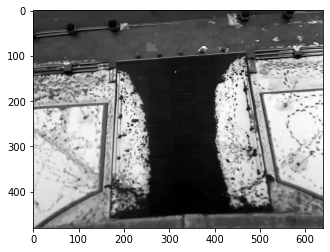

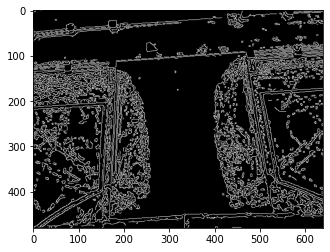

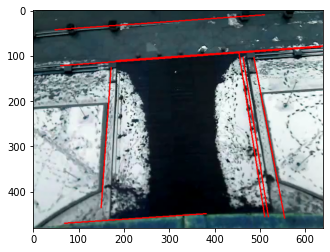

Duz[(x1:194,y1:112),(x2:634,y2:81), k:-0.07045454545454545,n:125.66818181818182]
Duz[(x1:48,y1:43),(x2:511,y2:10), k:-0.07127429805615551,n:46.42116630669546]
Duz[(x1:183,y1:111),(x2:639,y2:79), k:-0.07017543859649122,n:123.84210526315789]
Duz[(x1:150,y1:435),(x2:172,y2:126), k:-14.045454545454545,n:2541.8181818181815]
Duz[(x1:60,y1:122),(x2:383,y2:99), k:-0.07120743034055728,n:126.27244582043343]
Duz[(x1:69,y1:469),(x2:382,y2:448), k:-0.0670926517571885,n:473.62939297124603]
Duz[(x1:487,y1:104),(x2:555,y2:458), k:5.205882352941177,n:-2431.264705882353]
Duz[(x1:463,y1:103),(x2:519,y2:455), k:6.285714285714286,n:-2807.285714285714]
Duz[(x1:454,y1:93),(x2:511,y2:455), k:6.350877192982456,n:-2790.2982456140353]
Izracunat presek: Presek[Duz1:[Duz[(x1:194,y1:112),(x2:634,y2:81), k:-0.07045454545454545,n:125.66818181818182]] Duz2:[Duz[(x1:48,y1:43),(x2:511,y2:10), k:-0.07127429805615551,n:46.42116630669546]] Presek:(-96671.86826347219, 6936.640718562813)] Razdaljina: [9429572155.373816]
Izra

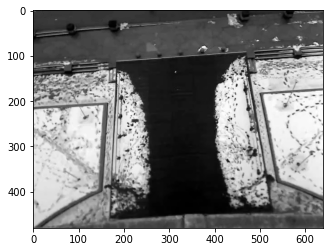

In [26]:
frame_num = 0
cap = cv2.VideoCapture("data/video1.mp4")
cap.set(1, frame_num) # indeksiranje frejmova

# analiza videa frejm po frejm
while True:
    frame_num += 1
    ret_val, frame = cap.read()

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plt.imshow(frame_gray, "gray")

    # ako frejm nije zahvacen
    if not ret_val:
        break

    if frame_num == 1: # ako je prvi frejm, detektuj liniju
        lines = detect_lines(frame)
        detect_rectangle(lines)
        time.sleep(30)
    else:
        break

In [5]:
def process_video(video_path):
    # procesiranje jednog videa
    # priprema pomocnih promenljivih
    sum_of_nums = 0
    k = 0
    n = 0
    
    # ucitavanje videa
    frame_num = 0
    cap = cv2.VideoCapture(video_path)
    cap.set(1, frame_num) # indeksiranje frejmova
    
    # analiza videa frejm po frejm
    while True:
        frame_num += 1
        ret_val, frame = cap.read()
        
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #plt.imshow(frame_gray, "gray")

        # ako frejm nije zahvacen
        if not ret_val:
            break
        
        if frame_num == 1: # ako je prvi frejm, detektuj liniju
            line_coords = detect_line(frame)
            line_left_edge = line_coords[0]
            line_right_edge = line_coords[2]
            # odredjivanje parametara jednacine prave y = kx + n
            k = (float(line_coords[3]) - float(line_coords[1])) / (float(line_coords[2]) - float(line_coords[0]))
            n = k * (float(-line_coords[0])) + float(line_coords[1])
            print("\nDetektovani parametri jednačine prave:")
            print("k=", k)
            print("n=", n)
        else:
            break

    cap.release()
    return sum_of_nums

analyzing video: data/video1.mp4


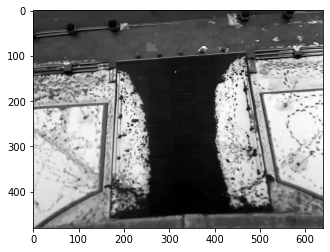

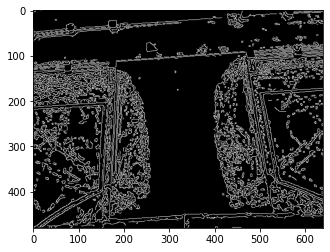

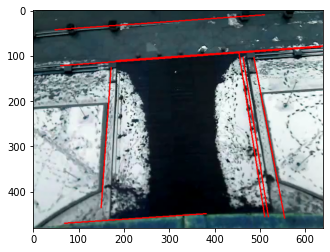

KeyboardInterrupt: 

In [242]:
BROJ_KLIPOVA = 10
suma = 0
for i in range(1, 9):
    path = "data/video" + str(i) + ".mp4"
    print("analyzing video: " + path)
    try:
        f = open(path)
    except IOError:
        print("Fajl ne postoji. Da li ste preuzeli klipove i stavili ih u data/ direktorijum")
    finally:
        f.close()
    suma += process_video(path)